# Modeling
@Author: Bruno Vieira

Goals: Create a classification model able to identify a BOT account on twitter, using only profile-based features.

In [89]:
# Libs
import os
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score, average_precision_score, f1_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
import cloudpickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import utils.dev.model as mdl
import importlib
pd.set_option('display.max_columns', 100)

In [75]:
# Paths and Filenames
DATA_INPUT_PATH = 'data/interim'
DATA_INPUT_TRAIN_NAME = 'train_selected_features.csv'
DATA_INPUT_TEST_NAME = 'test.csv'
MODEL_OUTPUT_PATH = 'models'
MODEL_NAME = 'model_bot_classifier_v0'

In [76]:
df_twitter_train = pd.read_csv(os.path.join('..',DATA_INPUT_PATH, DATA_INPUT_TRAIN_NAME))
df_twitter_test = pd.read_csv(os.path.join('..',DATA_INPUT_PATH, DATA_INPUT_TEST_NAME))

In [49]:
df_twitter_train.replace({False:'FALSE', True:'TRUE'}, inplace=True)
df_twitter_test.replace({False:'FALSE', True:'TRUE'}, inplace=True)

# 1) Training

In [50]:
X_train = df_twitter_train.drop('label', axis=1)
y_train = df_twitter_train['label']
cat_columns = df_twitter_train.select_dtypes(include=['bool', 'object']).columns.tolist()
num_columns = df_twitter_train.select_dtypes(include=['int32','int64','float32', 'float64']).columns.tolist()
num_columns.remove('label')

In [66]:

skf = StratifiedKFold(n_splits=10)
cat_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), 
                                   ('encoder', OneHotEncoder(handle_unknown='ignore'))])
num_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
                                   ('scaler', MinMaxScaler())])

pipe_transformer = ColumnTransformer(transformers=[('num_pipe_preprocessor', num_preprocessor, num_columns),
                                                   ('cat_pipe_preprocessor', cat_preprocessor, cat_columns)])
pipe_model = Pipeline(steps=[('pre_processor', pipe_transformer), 
                             ('model', SVC(random_state=23, kernel='rbf', gamma='scale', C=1, probability=True))])

In [72]:
cross_validation_results = cross_validate(pipe_model, X=X_train, y=y_train, scoring=['average_precision', 'roc_auc', 'precision', 'recall'], cv=skf, n_jobs=-1, verbose=0, return_train_score=True)

In [74]:
pipe_model.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('num_pipe_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['name', 'followers_count',
                                                   'friends_count',
                                                   'listed_count',
                                                   'favourites_count',
                                                   'rate_friends_followers',
                                                   'unique_colors']),
                    

# 2) Evaluation

In [79]:
cross_validation_results = pd.DataFrame(cross_validation_results)

In [80]:
cross_validation_results

,fit_time,score_time,test_average_precision,train_average_precision,test_roc_auc,train_roc_auc,test_precision,train_precision,test_recall,train_recall
0,28.251936,1.663325,0.822254,0.717450,0.809445,0.685074,0.731343,0.643571,0.739224,0.708513
1,28.514303,1.661737,0.756801,0.719327,0.725310,0.689589,0.646681,0.645197,0.650862,0.701817
2,27.848434,1.848148,0.747670,0.727840,0.707189,0.692981,0.636917,0.645083,0.675269,0.702942
3,28.392506,1.721762,0.705080,0.710988,0.674730,0.682604,0.645749,0.644644,0.686022,0.702464
4,27.648945,1.806094,0.660182,0.718484,0.621055,0.689562,0.628283,0.644335,0.668817,0.722315
5,28.540884,1.699635,0.729675,0.715753,0.698297,0.685462,0.649225,0.640678,0.720430,0.723272
6,27.845924,1.637209,0.653986,0.727438,0.636221,0.694881,0.617934,0.648313,0.681720,0.712509
7,28.313765,1.708702,0.723285,0.722794,0.700169,0.690701,0.638489,0.645664,0.763441,0.703420
8,28.286296,1.708704,0.715701,0.717566,0.666471,0.690333,0.639929,0.638994,0.773707,0.728838
9,28.170767,1.717810,0.657866,0.725930,0.607402,0.698253,0.603416,0.651630,0.685345,0.697752


## 2.1) Metrics

In [81]:
y_train_predict = pipe_model.predict_proba(X_train)


In [85]:
df_metrics_train = mdl.eval_thresh(y_real = y_train, y_proba = y_train_predict[:,1])


/Users/bruno.santos/Desktop/Mestrado/mestrado_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bruno.santos/Desktop/Mestrado/mestrado_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bruno.santos/Desktop/Mestrado/mestrado_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bruno.

In [92]:
importlib.reload(mdl)

<module 'utils.dev.model' from '/Users/bruno.santos/Desktop/Mestrado/projects/bot_detection_twitter_profile_features/utils/dev/model.py'>

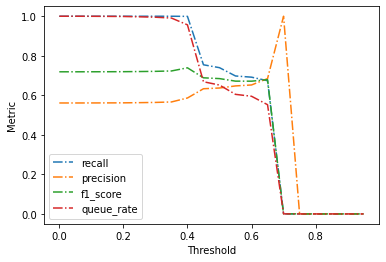

None

In [93]:
mdl.plot_metrics(df_metrics_train)

## 2.2) Ordering

## 2.2) Callibration